In [1]:
data_fp = '/home/theo/research/courses/12.843/data' # path for data
figs_fp = '/home/theo/research/courses/12.843/figs' # path to save figs

In [2]:
import xarray as xr
import scipy.io as sio
from scipy.fft import fft, ifft
from matplotlib.path import Path
import pickle
from scipy.stats import pearsonr
from os.path import join
import numpy as np
from glob import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmocean
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import pandas as pd
from copy import deepcopy
    
### Specify figure resolution
scale = 1
mpl.rcParams['figure.dpi']        = 150 # set figure resolution (dots per inch) 
mpl.rcParams['hatch.linewidth']   = .15  * scale
mpl.rcParams['axes.labelsize']    = 11  * scale
mpl.rcParams['axes.titlesize']    = 13  * scale
mpl.rcParams['xtick.labelsize']   = 9   * scale
mpl.rcParams['ytick.labelsize']   = 9   * scale
mpl.rcParams['lines.linewidth']   = 1   * scale
mpl.rcParams['legend.fontsize']   = 8   * scale
mpl.rcParams['patch.linewidth']   = 1   * scale
mpl.rcParams['contour.linewidth'] =.5   * scale
mpl.rcParams['axes.labelpad']     = 4 * scale   # space between label and axis
mpl.rcParams['xtick.major.pad']   = 0 * scale   # distance to major tick label in points
mpl.rcParams['ytick.major.pad']   = mpl.rcParams['xtick.major.pad']
mpl.rcParams['lines.markersize']  = 3 * scale

### cartopy-specific parameters
gridline_width                    = .7 * scale
border_width                      = .3 * scale

### manually specified colorbar params
tick_width                        = 0 * scale # controls size of tickmark next to labels
tick_length                       = 2 * scale

$\zeta = \frac{1}{R\cos{\theta}}\Big[\frac{\partial}{\theta}\left(u\cos{\theta}\right) - \frac{\partial v}{\partial \phi}\Big]$

Load data and convert to polar coords

In [3]:
u = xr.open_dataset(join(data_fp,'era5_u_843.nc')).u.sel(latitude=slice(50,0),
                                                         longitude=slice(220,260)).compute()
v = xr.open_dataset(join(data_fp,'era5_v_843.nc')).v.sel(latitude=slice(50,0),
                                                         longitude=slice(220,260)).compute()

## Convert to polar coords
lon            = deepcopy(u.longitude) # copy of original coords for plotting
lat            = deepcopy(u.latitude)
theta          = np.deg2rad(u.latitude).values
phi            = np.deg2rad(u.longitude).values
u              = u.rename({'longitude':'phi', 'latitude':'theta'})
v              = v.rename({'longitude':'phi', 'latitude':'theta'})
u['phi']       = phi
v['phi']       = phi
u['theta']     = theta
v['theta']     = theta

Compute vorticity

In [4]:
R     = 6.37e6
omega = 7.29e-5 
f     = 2*omega * np.sin(u['theta'])

## Relative vorticity
dv_dphi             = -v.differentiate('phi')
u_cos_theta         =  u * np.cos(u['theta'])

dtheta_du_cos_theta = -u_cos_theta.differentiate('theta')
zeta                = 1 / (R*np.cos(u['theta'])) * (dtheta_du_cos_theta - dv_dphi)

## Absolute vorticity
eta                 = zeta + f

Plot

In [25]:
def plot_frame(ti):
    figsize=(5,4)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection=ccrs.PlateCarree(central_longitude=180))
    ax.set_extent([220,260,10,30], crs=ccrs.PlateCarree())
    ax.coastlines(linewidth=border_width)
    ax.add_feature(cfeature.BORDERS, zorder=1, linewidth = border_width)
    gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=.1, linewidth=gridline_width, color='k', zorder=1.05)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': mpl.rcParams['xtick.labelsize']}
    gl.ylabel_style = {'size': mpl.rcParams['ytick.labelsize']}

    cp1 = ax.contourf(lon,lat, eta.isel(time=ti, level=1),                  
                      extend='both',  cmap='cmo.amp', levels=np.arange(0,10e-4,10e-5),transform=ccrs.PlateCarree())
    cb = fig.colorbar(cp1, fraction=.02)
    cb.set_label("abs. vor. (s$^{-1}$)")

    #### Quiver plot
    n=7
    x,y = np.meshgrid(lon[::n].values, lat[::n].values)
    qv = ax.quiver(x,y, u.isel(time=ti, level=1).values[::n,::n], 
                   v.isel(time=ti, level=1).values[::n,::n], 
                   scale=.5e3, color='black', alpha=.6, transform=ccrs.PlateCarree(), pivot='middle')
    return fig, ax

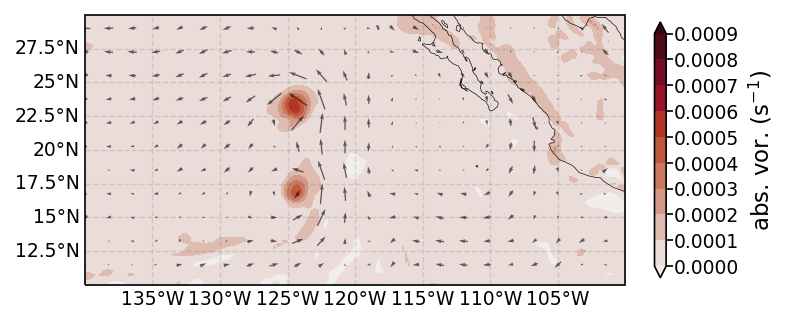

In [27]:
fig,ax = plot_frame(41)
plt.show()

Make animation figures

In [11]:
t=40
for t in range(len(u.time)):
    fig,ax = plot_frame(t)
    fig.savefig(join(figs_fp, f'zoomed_{t:03d}.png'))
    plt.close(fig)

Tracking?

In [4]:
idx = np.argsort(zeta.isel(level=1,time=0).stack(n=['latitude','longitude']).values)
zeta.isel(level=1,time=0).stack(n=['latitude','longitude']).values[idx[-5:]]

KeyError: 'latitude'